<img src="results/latex.png" alt="logo" width="400px" style="float: right;">

# $\rm \textbf{Introduction to}$ ``pySYD`` 

In [2]:
# python imports
import pickle
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Box1DKernel, convolve

# pysyd-related imports
import pysyd
from pysyd import pipeline
from pysyd import utils

%matplotlib inline

## $\rm \textbf{Load in the star data}$

Main functions are called through ``pysyd.pipeline``. <br>
Let's load in data for our least-evolved example star: **1435467**

In [3]:
star = pipeline.load(star='1435467', CLI=False, verbose=True)



------------------------------------------------------
Target: 1435467
------------------------------------------------------
# LIGHT CURVE: 37919 lines of data read
# Time series cadence: 59 seconds
# POWER SPECTRUM: 99518 lines of data read
# PS is oversampled by a factor of 5
# PS resolution: 0.426868 muHz


For now, we'll keep the verbose option set to ``True`` so that we can see
what the software is doing.

For this target, both the light curve and power
spectrum were provided and loaded in. In this scenario, the software will automatically 
compute the oversampling factor (if applicable). This is reflected in the printed resolution,
which corresponds to the frequency resolution of the critically-sampled PS.

The ``star`` is an important moving part of the ``pySYD`` software, which is an instance of
the ``target.Target`` class. A new ``Target`` is created for each processed star, and contains
a whole range of information. For more details see our [API](https://pysyd.readthedocs.io/en/latest/target.html).

## $\rm \textbf{Don't know what}\,\, \nu_{max} \,\, \textbf{is for your star? Scratch that. Don't even know where to start?}$

$\rm \textbf{Don't worry, our first module can help with that!}$

In [4]:
star = utils.get_findex(star)
star.find_excess()

------------------------------------------------------
Running find_excess module:
PS binned to 319 datapoints
Binned freq res: 1.20 muHz
power excess trial 1: numax = 1415.99 +/- 87.35
S/N: 2.95
power excess trial 2: numax = 1455.96 +/- 77.51
S/N: 6.27
power excess trial 3: numax = 1428.00 +/- 94.18
S/N: 17.00
selecting model 3


The first utility function merely sets up parameters and arrays to successfully run the module.

Let's take a look at the output figure.

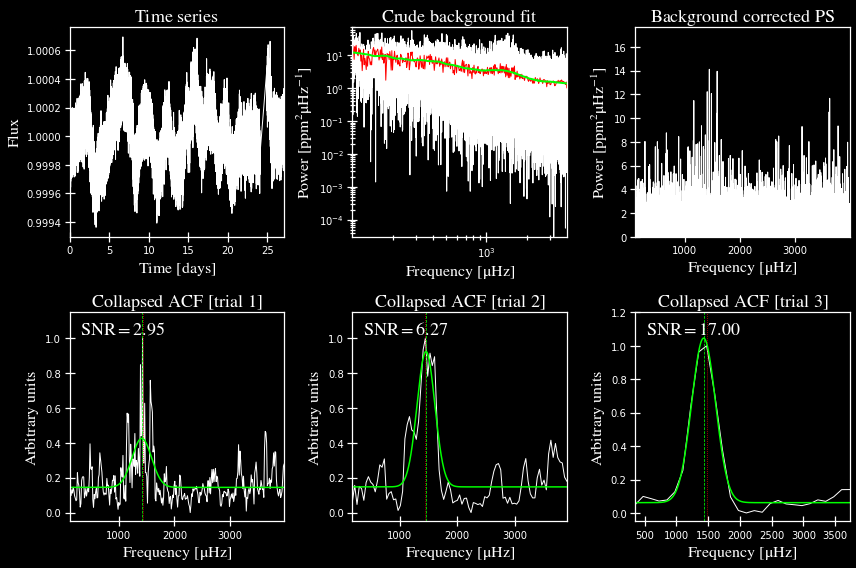

In [5]:
with open('excess.pickle','rb') as file:
    fig = pickle.load(file)
plt.show()

Ok, let's unpack. 

<b><u>Top:</b></u><br>
The top left panel shows the time series data as a sanity check (but does not do any altering of the light curve). The top middle panel shows the power spectrum (PS) in log-log space. The PS is binned (red) and heavily smoothed (lime green) as a quick but efficient method to determine the approximate background contribution due to stellar granulation. The reason for this step is that the value of numax for some stars can vary greatly if these effects are not considered. The background-corrected power spectrum (BCPS) in the top right panel is the original (white) power spectrum divided by the heavily-smoothed (green) power spectrum.

<b><u>Bottom:</b></u><br>
The three panels show the frequency-resolved, collapsed autocorrelation function (ACF) computed from the BCPS using three different box (or bin) sizes. A Gaussian is fit to each ACF, where the ``trial`` yielding the highest SNR peak is adopted as our initial guess for $\nu_{\mathrm{max}}$. In this case, the measured values were all self-consistent but this will not always be the case (i.e. use your best judgement).

## $\rm \textbf{Now that we have an appoximate starting point for}\,\, \nu_{max}, \,\, \textbf{we can run the next module}$

(this routine does a majority of the heavy lifting)

In [6]:
# the conditional checks if there is an estimate for numax 
# Note: numax is required for this module to run properly

if utils.check_fitbg(star):
    star = utils.get_fitbg(star)
    star.fit_global()

------------------------------------------------------
Running fit_background module:
PS binned to 195 data points
Comparing 3 different models:
Model 0: Flat white-noise term only
Model 1: White noise term + 1 Harvey-like component(s)
Model 2: White noise term + 2 Harvey-like component(s)
Based on BIC statistic: model 2
 **background-corrected PS saved**
----------------------------------------------------
Output parameters:
numax_smooth: 1352.92 muHz
A_smooth: 1.51 ppm^2/muHz
numax_gauss: 1424.10 muHz
A_gauss: 0.51 ppm^2/muHz
FWHM: 286.80 muHz
dnu: 70.66 muHz
white: 1.33 ppm^2/muHz
tau_1: 308.86 s
sigma_1: 69.17 ppm
tau_2: 93.99 s
sigma_2: 72.05 ppm
----------------------------------------------------


Note that this one provided a conditional to start. Let me explain.

Near-surface convection driving the acoustic oscillations is a stochastic process, which is why we see oscillation modes over a range of frequencies. Luckily, we know approximately how wide this region is based on ensemble analyses from <i>Kepler</i>. Using a scaling relation, we determine this width based on the value for $\nu_{\mathrm{max}}$. This region is then masked out in the beginning steps of the second module to more accurately determinie the stellar background contribution. <b> Therefore, the second routine <u><i>requires</i></u> an appoximate estimate for $\nu_{\mathrm{max}}$ (and this is where the conditional comes in).</b>
    
Luckily, we have three places one can provide/find such value:

1. By running the first module discussed above
2. In the 'info/star_info.csv' (this is described in more detail in our [documentation](https://pysyd.readthedocs.io/en/latest/overview.html))
3. Via command line i.e. ``--numax`` xxxx.x

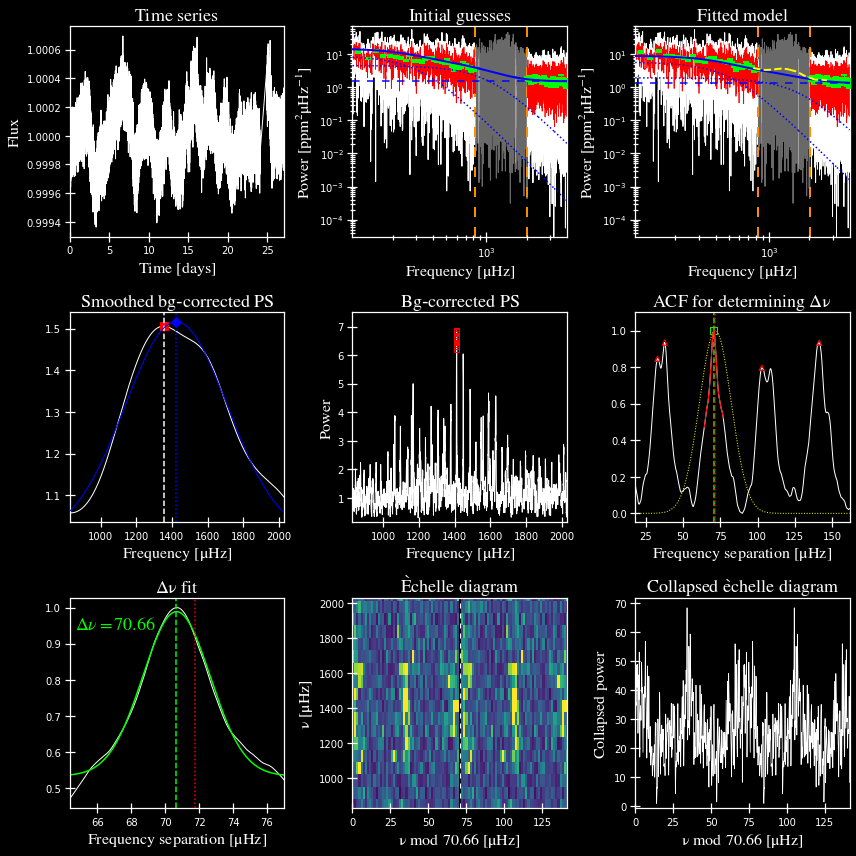

In [7]:
with open('background.pickle','rb') as file:
    fig = pickle.load(file)
plt.show()

<b><u>Top:</b></u><br>
So the first two figures should look somewhat familar from the first module (as they should because the light curve and power spectrum are exactly the same). In the second panel, we have a similar smoothed (red) power spectrum and then the binned (lime green) power spectrum. Like many other astrophysical phenomena, the stellar background consists of a combination of a single flat white-noise (horizontal blue dashed line) term and at least one red-noise component (curved blue dotted line(s)). The shaded power spectrum region delineated by the vertical orange dashed lines is exactly the power excess region we discussed above. The second and third panel are pretty similar, but the middle shows our initial guesses for these noise contributions and the right shows our final fit (i.e. the summed background total is the solid blue line). We use solar scaling relations for granulation timescales to estimate these initial guesses and as you can see, they do pretty well! Finally, the power excess is approximately Gaussian, shown by the dashed yellow line.

<b><u>Middle:</b></u><br>
The power spectrum is corrected by dividing out the best-fit background model, which means we are now ready to estimate the global asteroseismic parameters. We say the power excess is approximately Gaussian, but there is no physical reason to believe that the mode excitation is perfectly Gaussian. This is why we estimate $\nu_{\mathrm{max}}$ two ways: 1) using a heavily-smoothed power spectrum (white) and 2) by fitting a Gaussian (blue), which are both plotted together in the first panel. The middle panel shows the background-corrected PS (BCPS) centered on $\nu_{\mathrm{max}}$ and highlights some of the highest peaks (red). For acoustic oscillations that are equally spaced in frequency, the autocorrelation (ACF) is a powerful tool to quantitatively confirm the power excess. Therefore, the power in the middle figure is used to calculate the ACF shown in the third panel. Our peak corresponding to $\Delta\nu$ is highlighted, and we see harmonics at roughly half the spacing since the lowest order modes are separated by $\sim\Delta\nu/2$.


<b><u>Bottom:</b></u><br>
The first panel is zoomed in on the peak in the ACF closest to our expected $\Delta\nu$, which we fit with a Gaussian (green). Here, the red dashed line was our initial estimate based on a $\nu_{\mathrm{max}}$/$\Delta\nu$ scaling relation, so it was pretty close! Adopting the peak of the Gaussian as our value for $\Delta\nu$, we fold and stack the power spectrum in what is called an \`echelle diagram (which literally translates to ladder in French). This is shown in the middle panel, where we can see nice straight ridges corresponding to different oscillation modes. The right panel is similar to the middle plot but marganalizes over (or collapses) the y-axis, which is just another way to view this. Again, we see peaks in power that correspond to different oscillation modes.

## $\rm \textbf{So let's put this all together on another star.}$

In [8]:
star = pipeline.run(star='11618103', CLI=False)

Remember that by default, the verbose ouptut is ``False`` and is why we didn't see any output this time.

Let's take a look at the plots!

### $\rm \textbf{The first module:}$

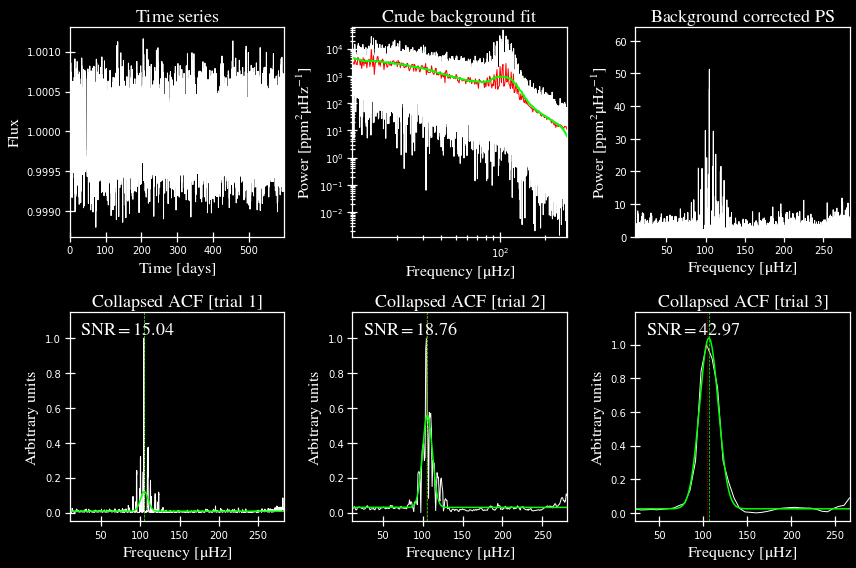

In [12]:
with open('excess.pickle','rb') as file:
    fig = pickle.load(file)
plt.show()

For this star, you might've noticed that $\nu_{\mathrm{max}}$ is lower by an order of magnitude. Additionally, the oscillations have much higher amplitudes! 

Indeed these are two well-known facts for characteristics of solar-like oscillations:

1. The frequency corresponding to maximum power (or $\nu_{\mathrm{max}}$) scales linearly will the surface gravity (log$g$) of the star.
2. Mode amplitudes scale with the luminosity of the star.

### $\rm \textbf{The second module:}$

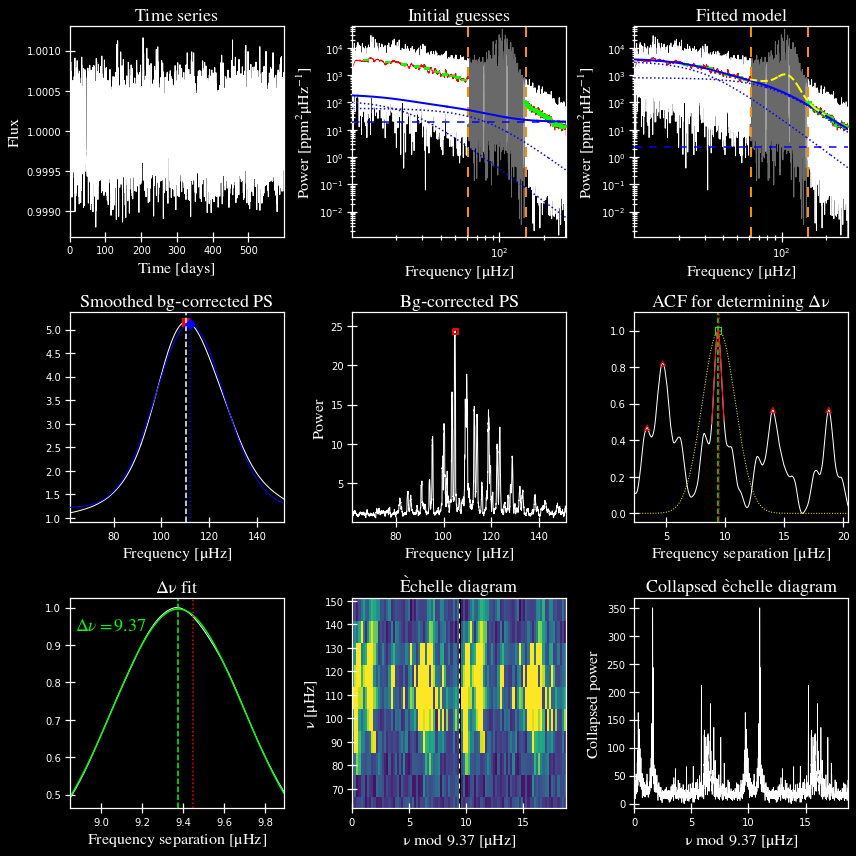

In [13]:
with open('background.pickle','rb') as file:
    fig = pickle.load(file)
plt.show()